_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 512)               309248    
_________________________________________________________________
dense_263 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_264 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_265 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_266 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_267 (Dense)            (None, 14)                3598      
Total params: 838,414
Trainable params: 838,414
Non-trainable params: 0
_________________________________________________________________
2505

<IPython.core.display.Javascript object>


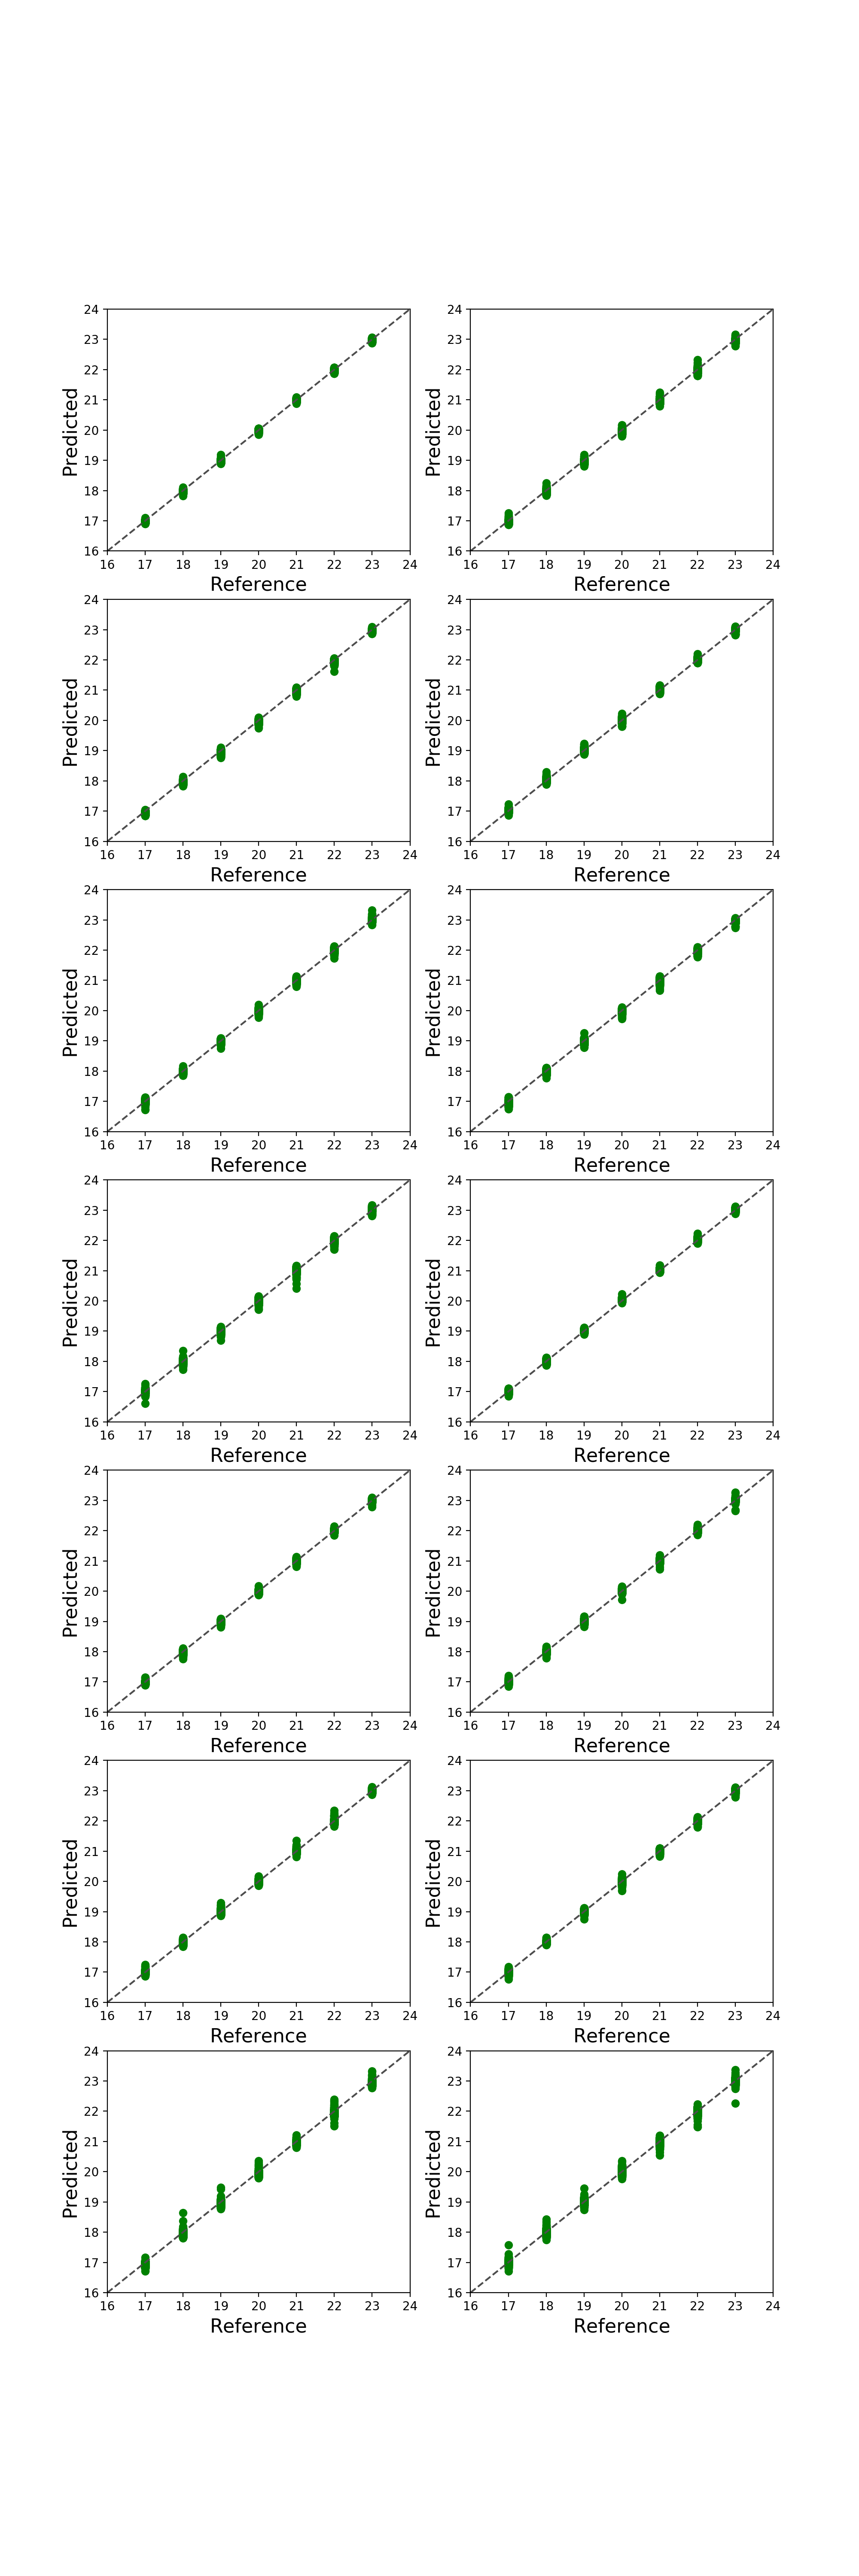

<IPython.core.display.Javascript object>


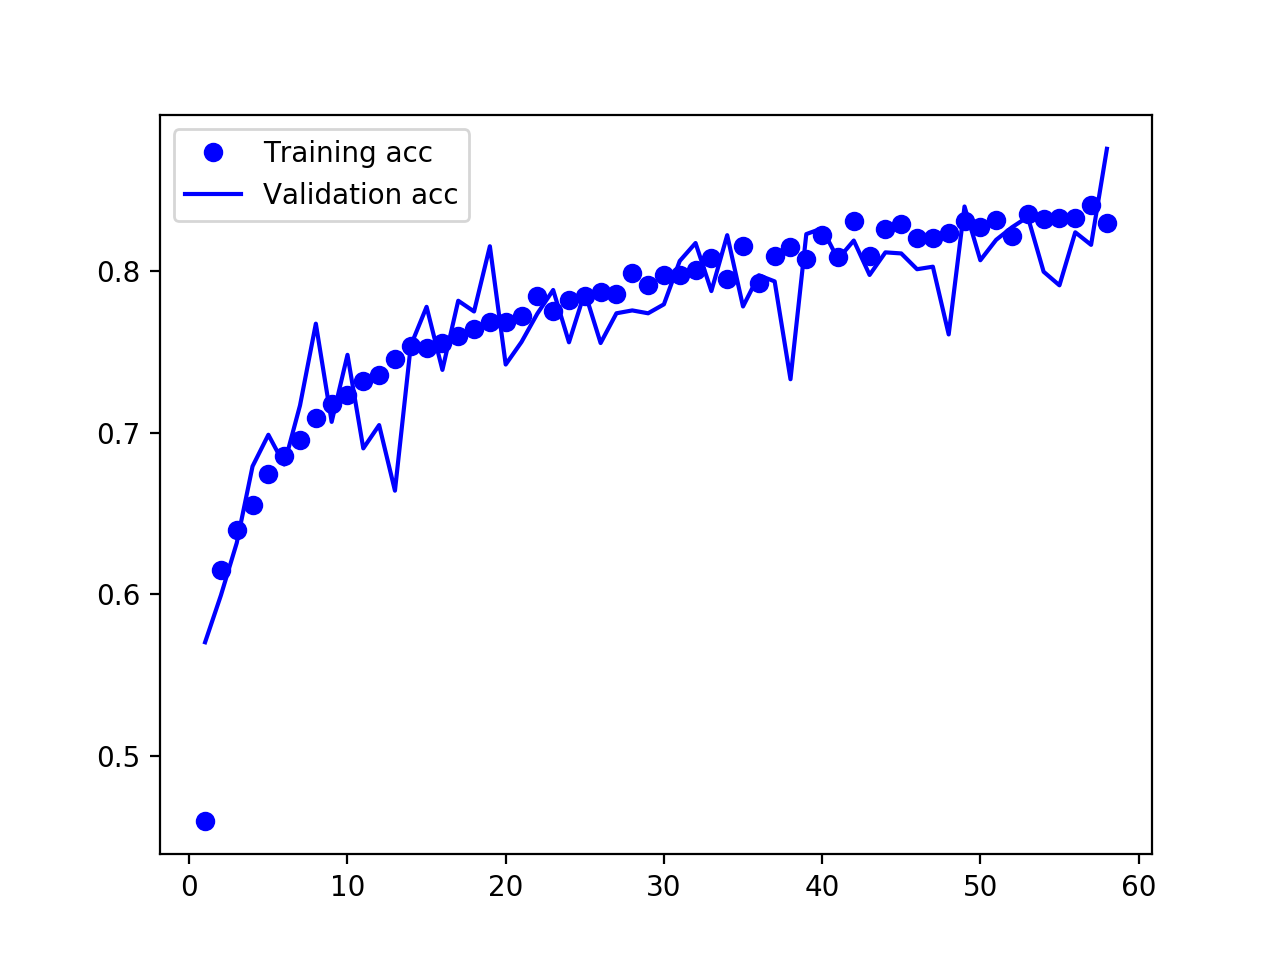

<IPython.core.display.Javascript object>


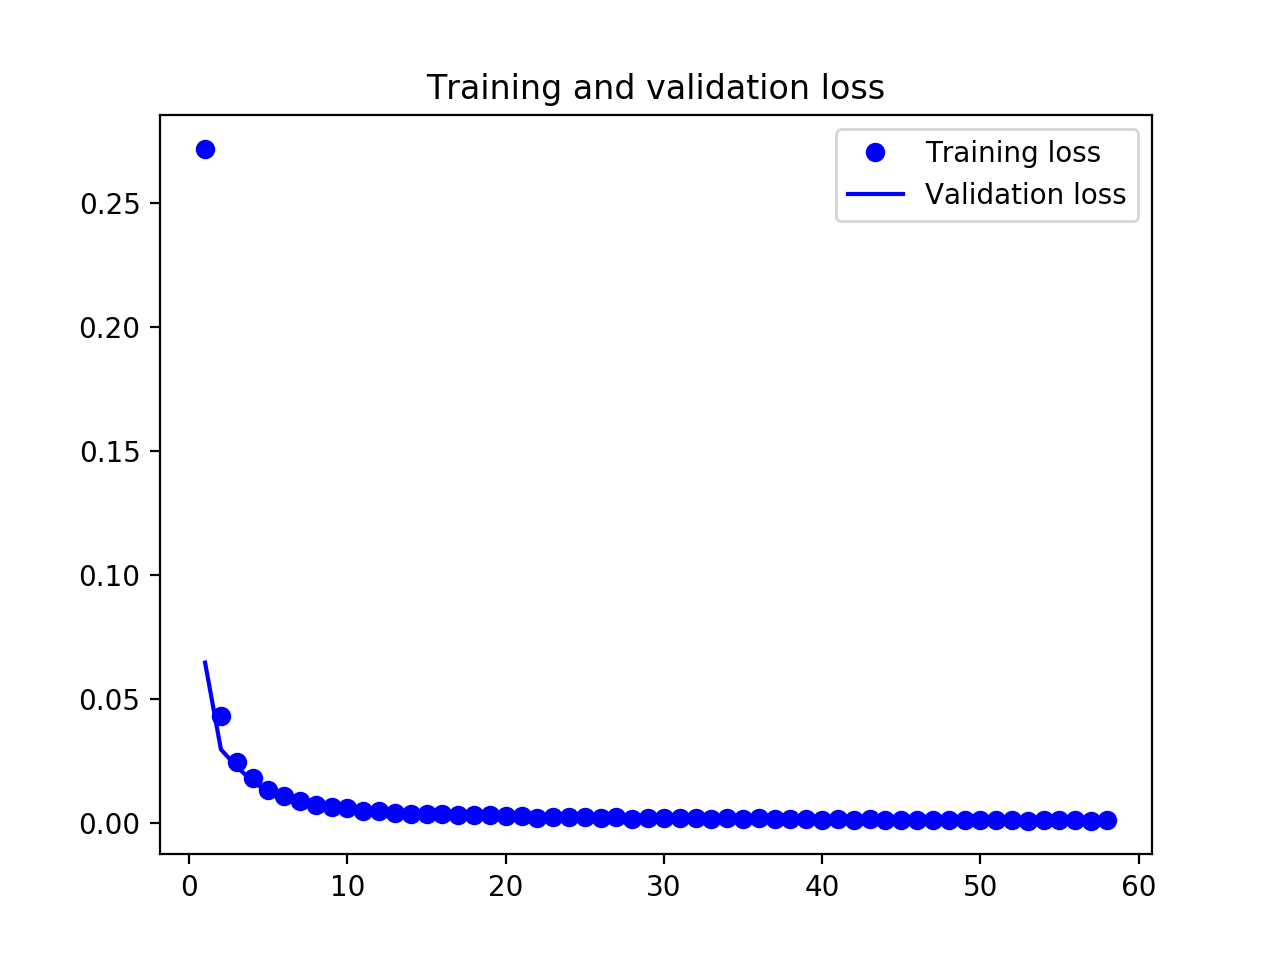

In [220]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern)

# set parameters:
n_times   = 50
test_size = 0.2
alpha     = 1e-6
sigma     = 1.0
xrd_dir   = "/Users/akanane/Documents/Research/ML_diffraction/data/AuPtSLxrd20x20x7-2"
xy_dir    = "/Users/akanane/Documents/Research/ML_diffraction/data/AuPtSLxy20x20x7-2"
res_dir   = "/Users/akanane/Documents/Research/ML_diffraction/ML-diffraction/results/AuPtSL20x20x7-2/"

# set up a list of directories:
samples = get_samples()

# read diffraction patterns:
difr, qgrid, ngrid1, ngrid2 = read_xrd(xrd_dir, samples, n_times)

# read composition profiles:
xgrid, comp, y = read_xy(xy_dir, samples, n_times)

dds = np.reshape(difr, (n_times*len(samples), difr.shape[2]))
dcp = np.reshape(comp, (n_times*len(samples), comp.shape[2]))
lyr = np.reshape(y,    (n_times*len(samples), y.shape[2]))

#kernel = RBF(length_scale=sigma, length_scale_bounds=(1e-5, 1e5))
#kernel = Matern(length_scale=sigma, length_scale_bounds=(1e-3, 1e3), nu=2.5)
#gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=20)
#x_train, x_test, y_train, y_test = train_test_split(dds, dcp, test_size=test_size)
#gp.fit(x_train, y_train)
#y_pred, sigma = gp.predict(x_test, return_std=True)
#plot_composition_compare(xgrid, y_pred[5,:], xgrid, y_test[5,:], "Predicted", "Reference")
#errors[:] = 0.0
#for m in range(Ntest): 
#    errors[m] = np.sqrt(np.mean((y_pred[m,:]-y_test[m,:])**2))
#    plot_compare(xgrid, y_pred[m,:], xgrid, y_test[m,:], "GPR predicted", "Reference", m, k, case, conv)
    #save_txt(xgrid, y_pred[m,:], xgrid, y_test[m,:], m, k, case, conv)
    # 
#x = get_input(qgrid, difr, times, ngrid1, peaks)

run_nn(dcp, lyr, res_dir)

In [195]:
def read_xy(xy_dir, samples, n_times):
    
    # each case contains different number of lines in xy file.
    # set up a grid of a minimum required number of points
    nxy_grid_raw = 6030
    dxy = 0.01
    xygrid_raw = np.linspace(0,nxy_grid_raw*dxy, nxy_grid_raw, False)
    
    nsamples = len(samples)
    xy_raw = np.zeros((nsamples, n_times, nxy_grid_raw))
    
    nlayers  = 7
    ndlayers = int(2*nlayers)
    
    y = np.zeros((nsamples, n_times, ndlayers))
     
    for ind_d, d in enumerate(samples):
        for n in range(n_times):
            filename = xy_dir + "/AuPtSLxy" + d + "_20x20x7-" + str(n)
            f = open(filename,"r")
            # when time is 0 read first 7 lines, layer numbers:
            for m in range(nlayers):
                line = f.readline()
                line2 = line.split()
                v1 = float(line2[0])
                v2 = float(line2[1])
                y[ind_d, n, m]   = v1
                y[ind_d, n, m+7] = v2
            for k in range(nxy_grid_raw):
                line = f.readline()
                line2 = line.split()
                xyval = float(line2[1])
                xy_raw[ind_d, n, k] = xyval
                
            f.close()
        
    # apply coarser resolution here
    # new resolution will average over a set of points and take an average
    # x point new grid point
    dN = 10
    Nxygrid = int(nxy_grid_raw/dN)
    
    xygrid = np.zeros((Nxygrid))
    xy = np.zeros((nsamples, n_times, Nxygrid))
    
    for n in range(Nxygrid):
        xygrid[n] = np.mean(xygrid_raw[n*dN:n*dN+dN])
    
    for k in range(nsamples):
        for m in range(n_times):
            for n in range(Nxygrid):
                xy[k,m,n] = np.mean(xy_raw[k,m,n*dN:n*dN+dN])
        
    return xygrid, xy, y

In [215]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def run_nn(x, y, save_dir):
    
    # seet parameters:
    test_size = 0.1
    validation_size = 0.2
    batch_size = 32

    # split dataset into training and testing subsets:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    # normalize data, use training set mean and standard deviation:
    x_mean   = x_train.mean(axis=0)
    x_train -= x_mean
    x_std    = x_train.std(axis=0)
    x_train /= x_std
    
    y_mean   = y_train.mean(axis=0)
    y_train -= y_mean
    y_std    = y_train.std(axis=0)
    y_train /= y_std
    

    # create a NN model:
    model_DNN = compile_model(x.shape[1], y.shape[1])

    #early stopping:
    callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                 ModelCheckpoint(('chk_model.h5'), save_best_only=True,
                 save_weights_only=False)]

    # train DNN and store training info in history:
    history = model_DNN.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=200,
                        verbose=False,
                        callbacks=callbacks,
                        validation_split=validation_size
                        #validation_data=(x_test, y_test)
                        )

    # evaluate model and predict
    x_test -= x_mean
    x_test /= x_std
    
    y_pred = model_DNN.predict(x_test)
    score  = model_DNN.evaluate(x_test, y_test, verbose=1)
    
    y_out = y_pred*y_std + y_mean
    
    # calculate errors:
    rmsd = 0.0
    mae = 0.0
    for m in range(y_test.shape[0]):
        rmsd  += np.sqrt(np.mean((y_out[m,:]-y_test[m,:])**2))
        mae   += np.mean(np.abs(y_out[m,:]-y_test[m,:]))

    print (" RMSD ", rmsd/y_test.shape[0])
    print (" MAE ", mae/y_test.shape[0])
    
    plot_layer_numbers(y_test, y_out, save_dir)
    #save_layer_numbers(y_test, y_out, save_dir)

    # plot training statistics:
    acc      = history.history['acc']
    val_acc  = history.history['val_acc']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    nepochs = range(1, len(acc)+1)
    
    plt.figure()
    plt.plot(nepochs, acc, 'bo', label='Training acc')
    plt.plot(nepochs, val_acc, 'b', label='Validation acc')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(nepochs, loss, 'bo', label="Training loss")
    plt.plot(nepochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [197]:
import numpy as np
import sys
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern)

def run_gpr(x, y, sigma, alpha):
    
    test_size = 0.1
    
    # rescale:
    scalerx     = preprocessing.StandardScaler()
    scalerx.fit(x)
    x_scaled = scalerx.transform(x)
    
    scalery     = preprocessing.StandardScaler()
    scalery.fit(y)
    y_scaled = scalery.transform(y)
    y_mean   = scalery.mean_
    y_std    = scalery.scale_

    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=test_size)

    #kernel = RBF(length_scale=sigma, length_scale_bounds=(1e-5, 1e5))
    
    kernel = Matern(length_scale=sigma, length_scale_bounds=(1e-5, 1e5), nu=5./3)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)
    
    gp.fit(x_train, y_train)
    y_pred, sigma = gp.predict(x_test, return_std=True)
    
    y_out = y_pred*y_std + y_mean
    y_in  = y_test*y_std + y_mean

    mae = 0.0
    rmsd = 0.0
    for m in range(x_test.shape[0]): 
        #print (y_pred[m,:],y_test[m,:])
        mae  += np.sum(np.abs(y_out[m,:]-y_in[m,:]))/len(y_out[m,:])
        rmsd += np.sqrt(np.sum(np.square(np.abs(y_out[m,:]-y_in[m,:])))/len(y_out[m,:]))
        
    plot_layer_numbers(y_out, y_in)

    print (" MAE ", mae/x_test.shape[0])
    print (" RMSD ", rmsd/x_test.shape[0])
    
    return rmsd/x_test.shape[0]

In [198]:
def read_xrd(base_dir, samples, ndata):
    
    scaling_factor = 1e10
    
    # take low Q features with Q=[25,29]
    # and high Q features with Q=[51,58]
    qminL = 25.0
    qmaxL = 29.0
    qminH = 51.0
    qmaxH = 58.0
    dq = 0.01
    
    NQgridL = int((qmaxL - qminL)/dq)
    NQgridH = int((qmaxH - qminH)/dq)
    NQgrid = NQgridL + NQgridH
    
    dp = np.zeros((ndata, NQgrid))
    qgridL = np.linspace(qminL, qmaxL, NQgridL, False)
    qgridH = np.linspace(qminH, qmaxH, NQgridH, False)
    
    qgrid = np.concatenate((qgridL, qgridH), axis=0)
    
    nsamples = len(samples)
    difr = np.zeros((nsamples,ndata,NQgrid))
    
    # read xrd files
    for ind_d, d in enumerate(samples):
        for n in range(ndata):
            filename = base_dir + "/AuPtSLxrd" + d + "C20x20x7-"+str(n)
            f = open(filename,"r")
            m = 0
            for line in f:
                line2 = line.split()
                qval = float(line2[0])
                ints = float(line2[1])
                if qval >= qminL and qval < qmaxL:
                    difr[ind_d, n, m] = ints
                    m += 1
                if qval >= qminH and qval < qmaxH:
                    difr[ind_d, n, m] = ints
                    m += 1
            f.close()
    
    difr[:,:,:] /= scaling_factor
    
    return difr, qgrid, NQgridL, NQgridH

In [199]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_compare(x, y, x1, y1):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g')
    ax.plot(x1, y1, color='r', ls=':')
    ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [200]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_difference(x, y, y1):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y-y1, color='g')
    #ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [201]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_single(x, y):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g')
    #ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("Q",fontsize=fontsize)
    ax.set_ylabel("Intensity",fontsize=fontsize)

    plt.show()

In [202]:
def get_samples():
    samples = []
    samples.append('A001')
    
    for n in range(1,10,1):
        samples.append('C00'+str(n))
        
    for n in range(10,100,1):
        samples.append('C0'+str(n))
        
    for n in range(100,251,1):
        samples.append('C'+str(n))
        
    for n in range(1,10,1):
        samples.append('D00'+str(n))
        
    for n in range(10,100,1):
        samples.append('D0'+str(n))
        
    for n in range(100,251,1):
        samples.append('D'+str(n))
    
    return samples

In [203]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_data(x,y,data):
    """
       Plot errors in grid search
    
    """

    fontsize=16

    fig = plt.figure()
    ax  = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=2.0, vmax=5.0)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('RMSD',rotation=90,fontsize=fontsize)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.3f}".format(data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis values to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]

    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\alpha$',fontsize=fontsize)
    ax.set_ylabel('$\\sigma$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

In [219]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.initializers import glorot_uniform
from keras.activations import elu

# 512, 512, 256, 256, 256

def create_DNN(n_features, n_out):

    model = Sequential()
    
    seed = 0
    
    model.add(layers.Dense(512,input_shape=(n_features,),
                           activation='relu',kernel_initializer=glorot_uniform(seed=seed)))
    model.add(layers.Dense(512, activation='relu',kernel_initializer=glorot_uniform(seed=seed)))
    model.add(layers.Dense(256, activation='relu',kernel_initializer=glorot_uniform(seed=seed)))
    model.add(layers.Dense(256, activation='relu',kernel_initializer=glorot_uniform(seed=seed)))
    model.add(layers.Dense(256, activation='relu',kernel_initializer=glorot_uniform(seed=seed)))
    model.add(layers.Dense(n_out, activation='linear'))
    
    model.summary()
    
    return model

In [205]:
from keras import optimizers

def compile_model(n_features, n_out):
    
    # create the model
    model=create_DNN(n_features, n_out)
    # compile the model
    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])
    return model

In [206]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
import matplotlib.pyplot as plt

In [207]:
def plot_layer_numbers(y_test, y_pred, save_dir):
    
    fontsize=16
    
    vmin = 16
    vmax = 24
    
    N = y_test.shape[0]
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10), (ax11,ax12), (ax13,ax14)) = plt.subplots(7, 2, figsize=(10,30))
    
    ax1.axis([vmin,vmax,vmin,vmax])
    ax2.axis([vmin,vmax,vmin,vmax])
    ax3.axis([vmin,vmax,vmin,vmax])
    ax4.axis([vmin,vmax,vmin,vmax])
    ax5.axis([vmin,vmax,vmin,vmax])
    ax6.axis([vmin,vmax,vmin,vmax])
    ax7.axis([vmin,vmax,vmin,vmax])
    ax8.axis([vmin,vmax,vmin,vmax])
    ax9.axis([vmin,vmax,vmin,vmax])
    ax10.axis([vmin,vmax,vmin,vmax])
    ax11.axis([vmin,vmax,vmin,vmax])
    ax12.axis([vmin,vmax,vmin,vmax])
    ax13.axis([vmin,vmax,vmin,vmax])
    ax14.axis([vmin,vmax,vmin,vmax])
    
    ax1.plot(y_test[:,0], y_pred[:,0], 'o', color='g')
    ax2.plot(y_test[:,1], y_pred[:,1], 'o', color='g')
    ax3.plot(y_test[:,2], y_pred[:,2], 'o', color='g')
    ax4.plot(y_test[:,3], y_pred[:,3], 'o', color='g')
    ax5.plot(y_test[:,4], y_pred[:,4], 'o', color='g')
    ax6.plot(y_test[:,5], y_pred[:,5], 'o', color='g')
    ax7.plot(y_test[:,6], y_pred[:,6], 'o', color='g')
    ax8.plot(y_test[:,7], y_pred[:,7], 'o', color='g')
    ax9.plot(y_test[:,8], y_pred[:,8], 'o', color='g')
    ax10.plot(y_test[:,9], y_pred[:,9], 'o', color='g')
    ax11.plot(y_test[:,10], y_pred[:,10], 'o', color='g')
    ax12.plot(y_test[:,11], y_pred[:,11], 'o', color='g')
    ax13.plot(y_test[:,12], y_pred[:,12], 'o', color='g')
    ax14.plot(y_test[:,13], y_pred[:,13], 'o', color='g')
    
    ax1.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax2.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax3.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax4.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax5.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax6.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax7.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax8.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax9.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax10.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax11.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax12.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax13.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    ax14.plot([vmin,vmax],[vmin,vmax], ls="--", c=".3")
    
    ax1.set_xlabel('Reference',fontsize=fontsize)
    ax2.set_xlabel('Reference',fontsize=fontsize)
    ax3.set_xlabel('Reference',fontsize=fontsize)
    ax4.set_xlabel('Reference',fontsize=fontsize)
    ax5.set_xlabel('Reference',fontsize=fontsize)
    ax6.set_xlabel('Reference',fontsize=fontsize)
    ax7.set_xlabel('Reference',fontsize=fontsize)
    ax8.set_xlabel('Reference',fontsize=fontsize)
    ax9.set_xlabel('Reference',fontsize=fontsize)
    ax10.set_xlabel('Reference',fontsize=fontsize)
    ax11.set_xlabel('Reference',fontsize=fontsize)
    ax12.set_xlabel('Reference',fontsize=fontsize)
    ax13.set_xlabel('Reference',fontsize=fontsize)
    ax14.set_xlabel('Reference',fontsize=fontsize)
    
    
    ax1.set_ylabel('Predicted',fontsize=fontsize)
    ax2.set_ylabel('Predicted',fontsize=fontsize)
    ax3.set_ylabel('Predicted',fontsize=fontsize)
    ax4.set_ylabel('Predicted',fontsize=fontsize)
    ax5.set_ylabel('Predicted',fontsize=fontsize)
    ax6.set_ylabel('Predicted',fontsize=fontsize)
    ax7.set_ylabel('Predicted',fontsize=fontsize)
    ax8.set_ylabel('Predicted',fontsize=fontsize)
    ax9.set_ylabel('Predicted',fontsize=fontsize)
    ax10.set_ylabel('Predicted',fontsize=fontsize)
    ax11.set_ylabel('Predicted',fontsize=fontsize)
    ax12.set_ylabel('Predicted',fontsize=fontsize)
    ax13.set_ylabel('Predicted',fontsize=fontsize)
    ax14.set_ylabel('Predicted',fontsize=fontsize)
    
    plt.show()
    
    fname = save_dir + "all.pdf"
    plt.savefig(fname,dpi=1200,bbox_inches='tight')

In [208]:
import matplotlib.pyplot as plt
import os
from os import path

def plot_composition_compare(x, y, x1, y1, label1, label2):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g', label=label1)
    ax.plot(x1, y1, color='r', ls=':', label=label2)
    ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("d",fontsize=fontsize)
    ax.set_ylabel("Composition, %",fontsize=fontsize)

    plt.show()

In [212]:
def save_layer_numbers(y_in, y_out, save_dir):
    
    nsamples = y_in.shape[0]
    ndata = y_in.shape[1]
    
    for n in range(ndata):
        filename = save_dir + str(n+1) + ".txt"
        f = open(filename,"w")
        for m in range(nsamples):
            f.write(" %8.5f %8.5f \n"%(y_in[m,n], y_out[m,n]))
        
        f.close()